#Transformer Data Pipeline and Predictive Analysis

## Data Pipeline  
- Data ingestion from Supabase and Open-Meteo API (via transformer-weather-ingest: https://github.com/stephengilbert1/transformer-weather-ingest)  
- Data cleaning and integration

## Exploratory Data Analysis  
- Visualization of internal and ambient temperatures  
- Correlation analysis

## Predictive Modeling  
- Linear regression and forecasting transformer temperature  
- Model evaluation and applications

## Conclusion and Next Steps  
- Pipeline automation, deployment ideas, and model improvements

#Setup and Imports

Load libraries, environment variables, and configure plot styles

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json



from datetime import datetime, timedelta, timezone
from pathlib import Path
from supabase import create_client
from dotenv import load_dotenv
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

load_dotenv()

# --- Style defaults for consistency with portfolio ---
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Outfit", "Arial", "Helvetica", "DejaVu Sans"]
plt.rcParams["figure.facecolor"] = "#ffffff"
plt.rcParams["axes.facecolor"] = "#ffffff"
plt.rcParams["text.color"] = "#171717"
plt.rcParams["axes.labelcolor"] = "#171717"
plt.rcParams["xtick.color"] = "#171717"
plt.rcParams["ytick.color"] = "#171717"



SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_SERVICE_ROLE_KEY = os.getenv("SUPABASE_SERVICE_ROLE_KEY")

## Data Loading

This function will load transformer temperature readings and ambient temperature data from Supabase.
Transformer temperature data is generated by a vercel triggered cron job. This data is shared by the Transformer Dashboard application.
Ambient temperature data is obtained via the transformer-weather-ingest tool from Open-Meteo API. The database will likely have stale or missing ambient temperature data unless this tool has been executed recently.

In [6]:
def fetch_readings_from_supabase(days: int = 30, page_size: int = 1000, max_rows: int | None = None):
    client = create_client(SUPABASE_URL, SUPABASE_SERVICE_ROLE_KEY)
    since = (datetime.now(timezone.utc) - timedelta(days=days))\
        .isoformat(timespec="seconds").replace("+00:00", "Z")

    rows, offset = [], 0
    while True:
        q = (
            client.table("temperature_readings")      # or .postgrest.from_(...)
                  .select("transformer_id,timestamp,tempC, ambient_temperature")
                  .gte("timestamp", since)
                  .order("timestamp", desc=False)
                  .range(offset, offset + page_size - 1)
        )
        try:
            res = q.execute()
        except Exception as e:
            raise RuntimeError(f"Supabase fetch failed: {e}") from e

        batch = res.data or []
        rows.extend(batch)

        # stop conditions
        if len(batch) < page_size:
            break
        offset += page_size
        if max_rows and len(rows) >= max_rows:
            rows = rows[:max_rows]
            break

    return rows

DATA_PATH = Path("../data/readings.csv")
OUT_DIR = Path("../outputs")
OUT_DIR.mkdir(exist_ok=True)
OVERHEAT_THRESHOLD = float(os.getenv("OVERHEAT_THRESHOLD", "100"))


## Data Fetching and Cleaning

In this step, we fetch the latest 30 days of transformer temperature data and ambient temperature from Supabase.  
We convert timestamps to datetime format, print basic info about the fetched data, and clean it by removing rows with missing temperature values.


In [7]:
rows = fetch_readings_from_supabase(days=30, page_size=1000, max_rows=100000)
df = pd.DataFrame(rows)

# Parse timestamp, coerce errors to NaT
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

print("Fetched rows:", len(df))
print("time span:", df["timestamp"].min(), "→", df["timestamp"].max(), f"({len(df)} rows)")

# Drop rows where parsing of timestamp failed
num_bad_timestamps = df["timestamp"].isna().sum()
if num_bad_timestamps > 0:
    print(f"Dropping {num_bad_timestamps} rows with invalid timestamps")
df = df.dropna(subset=["timestamp"])

# Drop duplicate rows based on timestamp + temp columns (if duplicate readings exist)
num_duplicates = df.duplicated(subset=["timestamp", "tempC", "ambient_temperature"]).sum()
if num_duplicates > 0:
    print(f"Dropping {num_duplicates} duplicate rows")
df = df.drop_duplicates(subset=["timestamp", "tempC", "ambient_temperature"])

# Drop rows missing critical temperature data
df = df.dropna(subset=["tempC", "ambient_temperature"])

# Sort and reset index
df = df.sort_values("timestamp").reset_index(drop=True)

print(df[["tempC", "ambient_temperature"]].describe())
df.head()

Fetched rows: 19683
time span: 2025-07-22 15:00:00+00:00 → 2025-08-21 23:00:00+00:00 (19683 rows)
Dropping 79 duplicate rows
             tempC  ambient_temperature
count  7039.000000          7039.000000
mean     80.136313            18.882739
std      15.274796             3.602052
min      48.640000            10.500000
25%      67.225000            16.100000
50%      80.360000            18.400000
75%      92.825000            21.200000
max     110.980000            29.600000


,transformer_id,timestamp,tempC,ambient_temperature
0,XFMR-0004,2025-07-22 15:00:00+00:00,74.22,16.6
1,XFMR-0001,2025-07-22 15:00:00+00:00,64.68,17.5
2,XFMR-0010,2025-07-22 15:00:00+00:00,75.51,16.8
3,XFMR-0009,2025-07-22 15:00:00+00:00,71.08,17.3
4,XFMR-0005,2025-07-22 15:00:00+00:00,61.24,17.3


### Time Series for a Single Transformer

We select one transformer (either from the risk summary or the dataset) and prepare its temperature data over time.  
A 6-hour rolling average is computed to smooth short-term fluctuations.


In [8]:
t_id = df["transformer_id"].iloc[0]
df_one = df[df["transformer_id"] == t_id].copy().sort_values("timestamp")
df_one["rolling_6h"] = df_one["tempC"].rolling(window=6, min_periods=1).mean()

### Visualizing Transformer Temperature Trends

We plot the raw top-oil temperature and the 6-hour rolling average over time for the selected transformer, highlighting overall trends.


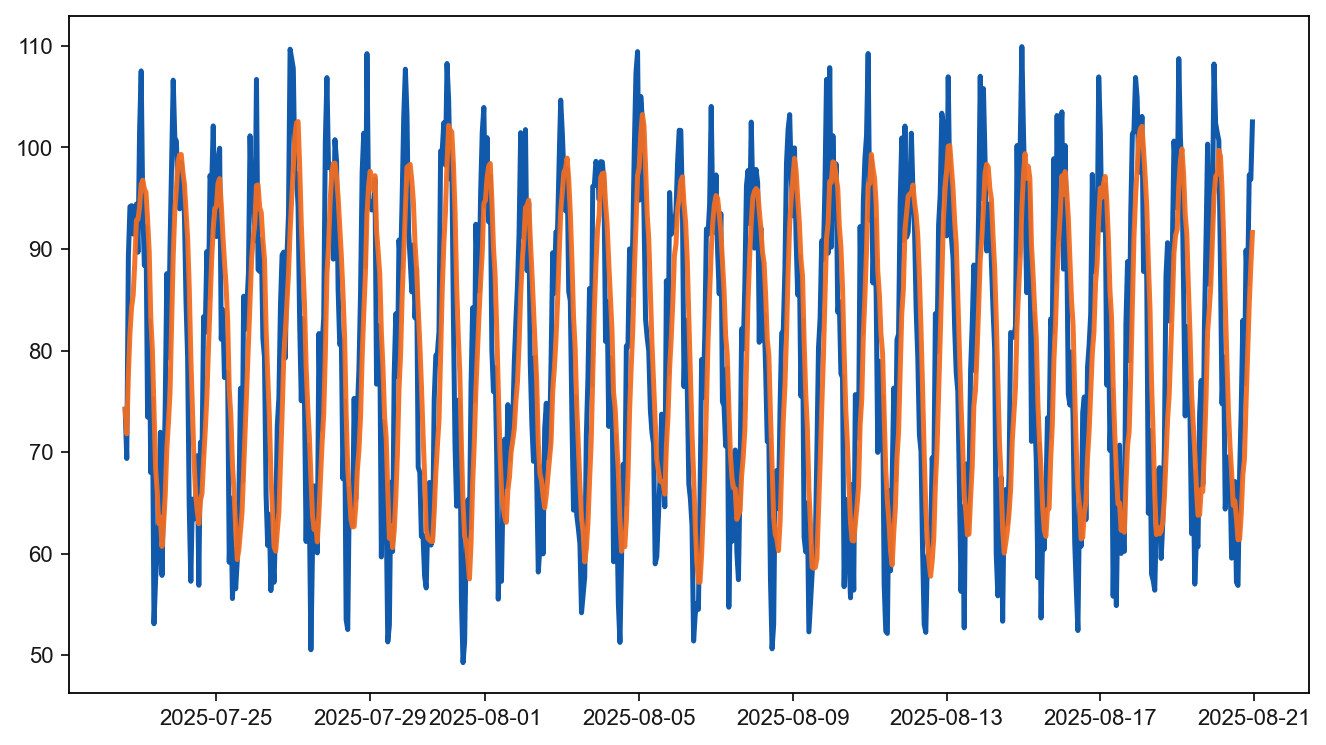

In [9]:
fig, ax = plt.subplots(figsize=(10, 5.5), dpi=160)

# Main series
ax.plot(df_one["timestamp"], df_one["tempC"], linewidth=2.25,
        label=f"{t_id} Top-Oil", color="#1059ab")

# Rolling average
ax.plot(df_one["timestamp"], df_one["rolling_6h"], linewidth=2.25,
        label="6-hr avg", color="#f26d21", alpha=0.95)

### Oil Temperature Rise Above Ambient

A key metric in transformer health monitoring is the oil temperature rise above the ambient temperature. This value helps isolate the temperature increase caused by transformer load and internal heat generation from the influence of surrounding environmental conditions.

By calculating temperature rise, we can better identify transformers experiencing abnormal heating patterns that may indicate thermal overload or emerging faults. This metric is also valuable for setting more meaningful thresholds and improving model features.

Below, we calculate this metric, provide summary statistics, and flag instances where the temperature rise exceeds a chosen critical threshold.


In [10]:
# Calculate oil temperature rise above ambient
df['temp_rise'] = df['tempC'] - df['ambient_temperature']

# Basic stats on temperature rise
print("Temperature rise above ambient:")
print(df['temp_rise'].describe())

# Example: flag rows where rise exceeds a threshold (e.g., 65°C)
threshold = 65
df['over_temp_rise'] = df['temp_rise'] > threshold
print(f"Number of readings with temperature rise > {threshold}°C:", df['over_temp_rise'].sum())


Temperature rise above ambient:
count    7039.000000
mean       61.253574
std        12.925993
min        31.650000
25%        50.860000
50%        61.460000
75%        71.495000
max        92.530000
Name: temp_rise, dtype: float64
Number of readings with temperature rise > 65°C: 2905


## Linear Regression Modeling

We use a simple linear regression model to predict transformer internal temperature (`tempC`) based on ambient temperature.  
This model will help us understand the relationship between ambient and internal temperatures and evaluate how well ambient temperature alone can explain internal temperature variations.


Linear regression coefficient (slope): 3.053
Intercept: 22.495
R^2 score: 0.518
Model equation: internal_temperature = 22.495 + 3.053 * ambient_temperature


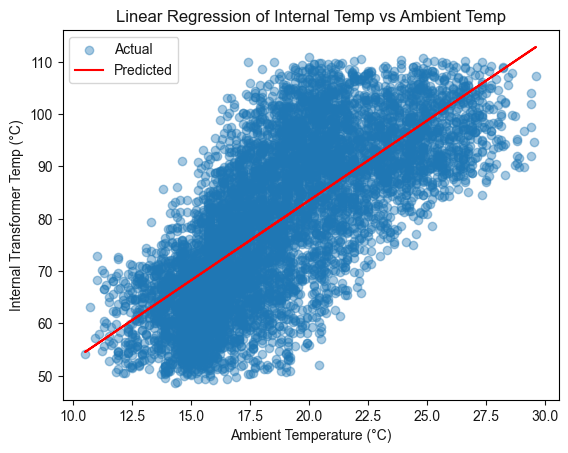

In [11]:


# Prepare X and y from cleaned df
X = df[['ambient_temperature']].values  # Predictor
y = df['tempC'].values                   # Response (internal temp)

model = LinearRegression()
model.fit(X, y)

df['predicted_tempC'] = model.predict(X)

print(f"Linear regression coefficient (slope): {model.coef_[0]:.3f}")
print(f"Intercept: {model.intercept_:.3f}")
print(f"R^2 score: {r2_score(y, df['predicted_tempC']):.3f}")

print(f"Model equation: internal_temperature = {model.intercept_:.3f} + {model.coef_[0]:.3f} * ambient_temperature")

# Plot results for quick visualization
plt.scatter(df['ambient_temperature'], df['tempC'], alpha=0.4, label='Actual')
plt.plot(df['ambient_temperature'], df['predicted_tempC'], color='red', label='Predicted')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('Internal Transformer Temp (°C)')
plt.legend()
plt.title("Linear Regression of Internal Temp vs Ambient Temp")
plt.show()

### Summary Statistics per Transformer

First, we ensure transformer IDs are strings for consistency.  
Then, we compute key summary statistics per transformer, including average and maximum internal temperatures, and the count of temperature readings.


In [12]:
# --- Ensure IDs are strings BEFORE any groupbys/joins ---
df["transformer_id"] = df["transformer_id"].astype(str)

# 1) Summary per transformer (avg/max/count)
summary = (
    df.groupby("transformer_id", as_index=True)
      .agg(
          avg_temp=("tempC", "mean"),
          max_temp=("tempC", "max"),
          count=("tempC", "size"),
      )
      .round(2)
)
summary.head()

,avg_temp,max_temp,count
transformer_id,,,
XFMR-0001,80.08,110.07,703
XFMR-0002,80.18,110.98,703
XFMR-0003,80.41,110.68,705
XFMR-0004,80.27,109.92,704
XFMR-0005,80.04,109.69,705


### Calculating Hours Above Threshold

We define a helper function using linear interpolation to calculate the number of hours each transformer’s temperature stayed above the defined overheating threshold within a specified time window.


In [13]:
def hours_over_threshold_window(g: pd.DataFrame, thresh: float,
                                start: pd.Timestamp, end: pd.Timestamp) -> float:
    s = g[["timestamp", "tempC"]].dropna().sort_values("timestamp")
    if len(s) < 2:
        return 0.0
    t0 = s["timestamp"].astype("int64").to_numpy() / 1e9
    t1 = s["timestamp"].shift(-1).astype("int64").to_numpy() / 1e9
    y0 = s["tempC"].to_numpy(dtype=float)
    y1 = s["tempC"].shift(-1).to_numpy(dtype=float)
    mask = ~np.isnan(t1)
    t0, t1, y0, y1 = t0[mask], t1[mask], y0[mask], y1[mask]
    if t0.size == 0:
        return 0.0

    start_s = start.value / 1e9
    end_s   = end.value   / 1e9
    sel = (t1 > start_s) & (t0 < end_s)
    if not np.any(sel):
        return 0.0
    t0, t1, y0, y1 = t0[sel], t1[sel], y0[sel], y1[sel]
    ts = np.maximum(t0, start_s)
    te = np.minimum(t1, end_s)

    denom = (t1 - t0)
    denom[denom == 0.0] = np.nan
    m = (y1 - y0) / denom  # °C/s

    above_ms = np.zeros_like(ts)

    both_above = (y0 > thresh) & (y1 > thresh)
    above_ms[both_above] = (te[both_above] - ts[both_above]) * 1000

    crossing = ((y0 > thresh) ^ (y1 > thresh)) & np.isfinite(m)
    if np.any(crossing):
        t_cross = t0[crossing] + (thresh - y0[crossing]) / m[crossing]
        falling = (y0[crossing] > thresh) & (y1[crossing] <= thresh)
        rising  = ~falling
        t_left  = np.maximum(ts[crossing], t_cross)
        t_right = np.minimum(te[crossing], t_cross)
        above_ms[crossing][falling] += np.maximum(0, (t_right[falling] - ts[crossing][falling]) * 1000)
        above_ms[crossing][rising]  += np.maximum(0, (te[crossing][rising] - t_left[rising]) * 1000)

    return float(above_ms.sum() / 3_600_000.0)  # ms -> hours


### Hours Over Temperature Threshold Across Time Windows

Using the function above, we compute how many hours each transformer’s temperature exceeded the overheating threshold in the last 24 hours, 7 days, and 30 days.


In [14]:
now_utc   = pd.Timestamp.now(tz="UTC")
start_24h = now_utc - pd.Timedelta(hours=24)
start_7d  = now_utc - pd.Timedelta(days=7)
start_30d = now_utc - pd.Timedelta(days=30)

over_24h = (
    df.groupby("transformer_id", group_keys=False)[["timestamp", "tempC"]]
      .apply(lambda g: hours_over_threshold_window(g, OVERHEAT_THRESHOLD, start_24h, now_utc))
      .rename("hours_over_thresh_24h")
)
over_7d = (
    df.groupby("transformer_id", group_keys=False)[["timestamp", "tempC"]]
      .apply(lambda g: hours_over_threshold_window(g, OVERHEAT_THRESHOLD, start_7d,  now_utc))
      .rename("hours_over_thresh_7d")
)
over_30d = (
    df.groupby("transformer_id", group_keys=False)[["timestamp", "tempC"]]
      .apply(lambda g: hours_over_threshold_window(g, OVERHEAT_THRESHOLD, start_30d, now_utc))
      .rename("hours_over_thresh_30d")
)

### Combined Risk Summary and Export

We join the summary statistics with the hours-over-threshold metrics to create a comprehensive risk table.  
This table is saved as a CSV file for further reporting and analysis.


In [15]:
risk = (
    summary
    .join(over_24h).join(over_7d).join(over_30d)
    .fillna(0)
)
risk[["hours_over_thresh_24h","hours_over_thresh_7d","hours_over_thresh_30d"]] = \
    risk[["hours_over_thresh_24h","hours_over_thresh_7d","hours_over_thresh_30d"]].astype(float).round(2)

risk.to_csv(OUT_DIR / "hot_transformers.csv")
print("Saved:", OUT_DIR / "hot_transformers.csv")

Saved: ..\outputs\hot_transformers.csv


### Preparing Data Payload for Web Visualization

Finally, we build a compact JSON dataset that includes time series temperatures and hours-over-threshold metrics per transformer.  
This JSON file can be consumed by web applications or dashboards for monitoring transformer health.

In [16]:
hours24_map = over_24h.to_dict()
hours7d_map = over_7d.to_dict()
hours30_map = over_30d.to_dict()

g = (
    df.loc[:, ["transformer_id", "timestamp", "tempC", "ambient_temperature"]]
      .dropna(subset=["timestamp", "tempC"])
      .sort_values("timestamp")
)

payload = {}
for tid, chunk in g.groupby("transformer_id", sort=True):
    ts = chunk["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    payload[tid] = {
        "t": ts.tolist(),
        "y": chunk["tempC"].astype(float).round(2).tolist(),
        "ambient": chunk["ambient_temperature"].astype(float).round(2).tolist(),
        "h": {
            "24h": round(float(hours24_map.get(tid, 0.0)), 3),
            "7d":  round(float(hours7d_map.get(tid, 0.0)), 3),
            "30d": round(float(hours30_map.get(tid, 0.0)), 3),
        },
    }

out_json = OUT_DIR / "series.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(payload, f, separators=(",", ":"))
print(
    f"Wrote {out_json} with {len(payload)} transformers and "
    f"{sum(len(v['t']) for v in payload.values())} total points."
)


Wrote ..\outputs\series.json with 10 transformers and 7039 total points.
